<a href="https://colab.research.google.com/github/panzershracker/Python-for-DS2/blob/master/AEvdokimov_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install catboost

     |████████████████████████████████| 62.9MB 37kB/s 


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from matplotlib import pyplot as plt
from pylab import rcParams

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score, confusion_matrix
import textwrap

import xgboost, catboost, lightgbm

import warnings

warnings.simplefilter('ignore')

### Работаю через colab, поэтому монтирую гуглодиск.

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/Python for DS 2/course_project_train.csv')

In [0]:
df_test = pd.read_csv('/content/drive/My Drive/Python for DS 2/course_project_test.csv')

In [0]:
def scatter_matrix(df):
  
  axs = pd.plotting.scatter_matrix(df, figsize=[20,20])

  def wrap(txt, width=8):
      '''helper function to wrap text for long labels'''
      return '\n'.join(textwrap.wrap(txt, width))

  for ax in axs[:,0]: # the left boundary
      ax.grid('off', axis='both')
      ax.set_ylabel(wrap(ax.get_ylabel()), rotation=0, va='center', ha='right', labelpad=20)
      ax.set_yticks([])

  for ax in axs[-1,:]: # the lower boundary
      ax.grid('off', axis='both')
      ax.set_xlabel(wrap(ax.get_xlabel()), rotation=90)
      ax.set_xticks([])
      
  return plt.show()

In [0]:
def corr_matrix(df, cmap='Greys'):
  
  corr = df.corr()

  mask = np.triu(corr, k=1)

  rcParams['figure.figsize'] = 14, 8

  sns.heatmap(corr, mask=mask, linewidths=.2, linecolor='lightgrey', cmap=cmap, annot=True)

  plt.xticks(rotation=50, horizontalalignment='right')

  plt.autoscale()

  return plt.show()

## Общие графики: матрица корреляций и матрица разброса.

##### Train corr. matrix

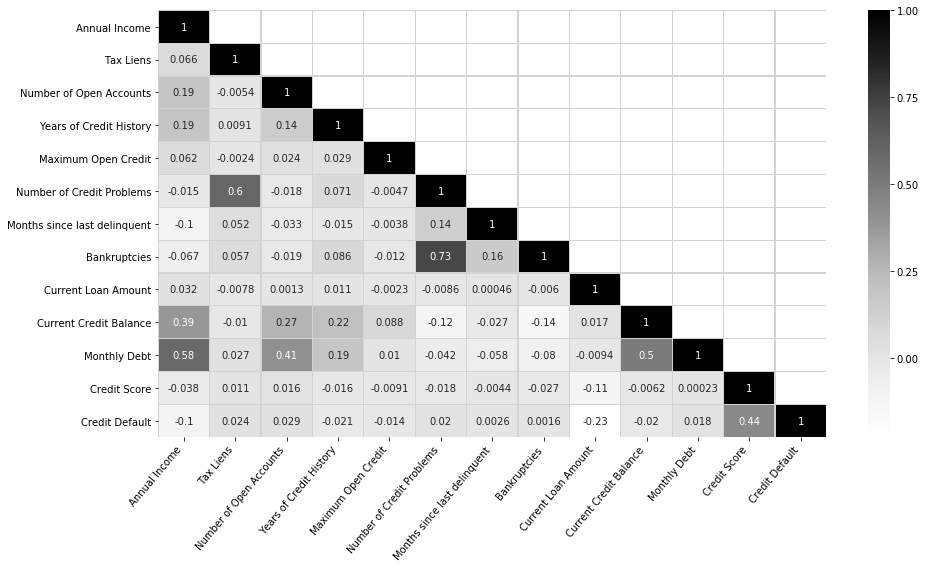

In [0]:
corr_matrix(df)

#! 
### Из матрицы корреляций видно, что с целевым признаком наиболее связан Credit score, и они имеют связь отдаленно похожую на линейную

##### Test corr. matrix

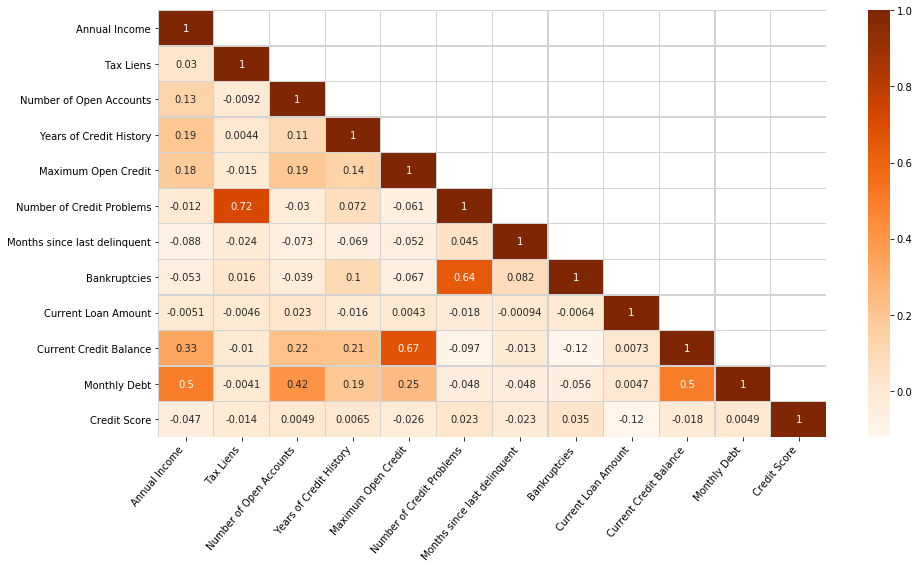

In [0]:
corr_matrix(df_test, cmap='Oranges')

##### Train Scatter matrix

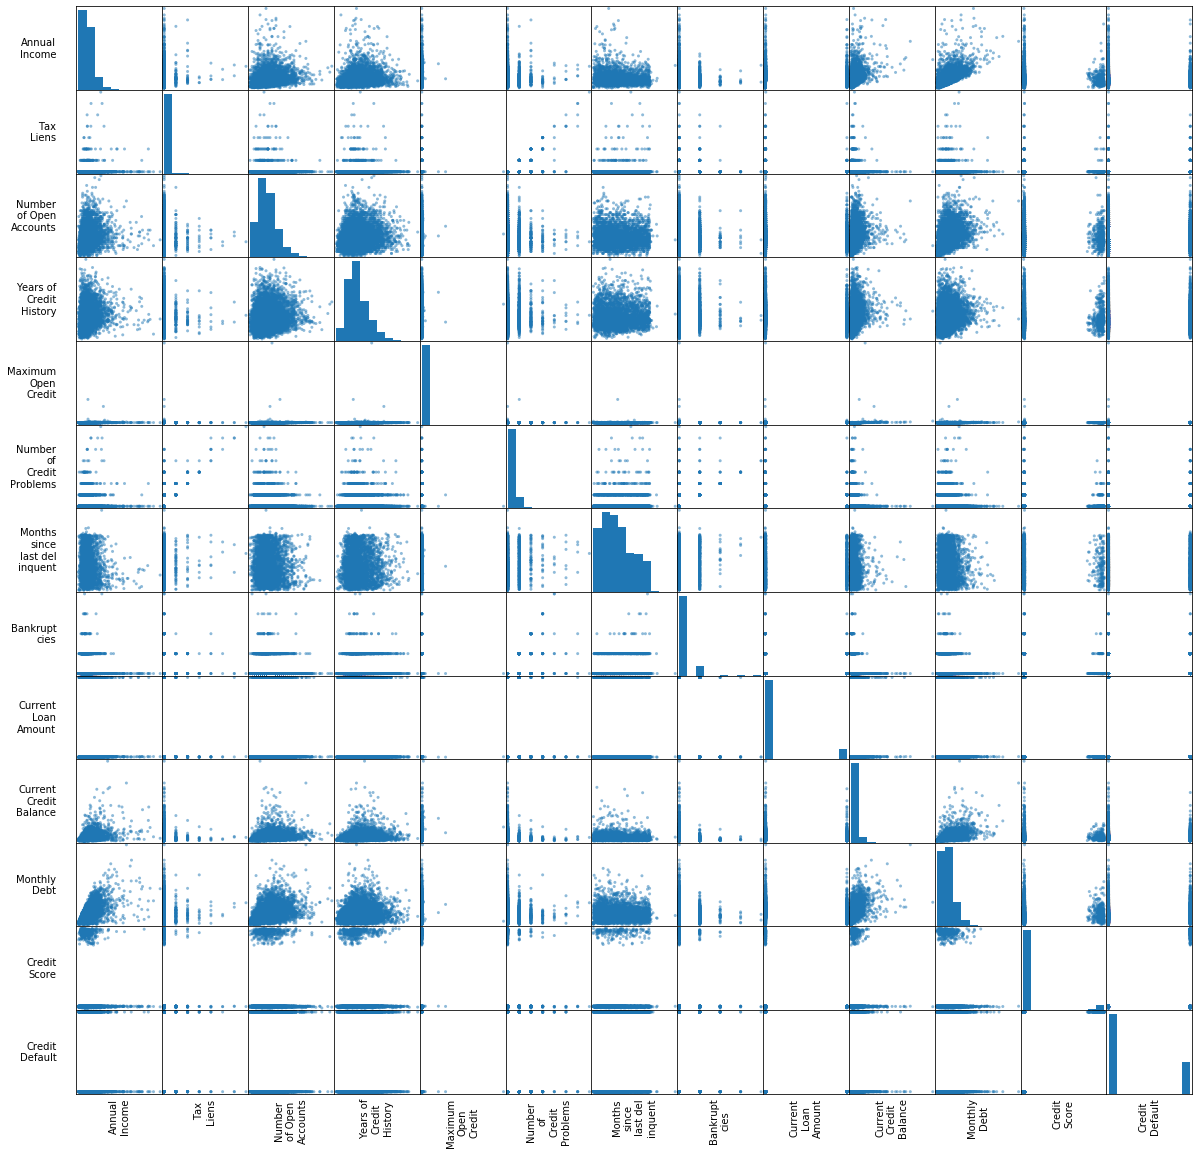

In [0]:
scatter_matrix(df)

# Некоторые функции для удобства

In [0]:
# Неудобно писать название колонки каждый раз - введем селектор по индексу:

def col(col_index):
  return df.columns[col_index]

In [0]:
def plt_size(x, y):
  rcParams['figure.figsize'] = x,y
  return rcParams['figure.figsize']

In [0]:
def scatter(x, y, sizex=5, sizey=5, df_alpha=1, dft_alpha=1, rot=True, df=df):
  if type(x) == int and type(y) == int:
    x = col(x)
    y = col(y)
  else:
    x = x
    y = y
  
  rcParams['figure.figsize'] = sizex, sizey

  plt.scatter(df[x], df[y], label='train', alpha=df_alpha)
  plt.scatter(df_test[x], df_test[y], label='test', alpha=dft_alpha)

  plt.legend()
  plt.xlabel(x, fontsize=17)
  
  if rot == True:
    plt.xticks(rotation=50, horizontalalignment='right')
  elif rot == False:
    plt.xticks(rotation=0, horizontalalignment='center')
    
  plt.ylabel(y, fontsize=17)

  plt.grid(alpha=.5)
  plt.ticklabel_format(style='plain')
  plt.title(f'{x} X {y}', size=20, fontweight='bold')
  plt.show()
  
  return plt.show()

In [0]:
# Функция балансировки классов

def balance(df, target):
  
  target_counts = df[target].value_counts()
  
  major = target_counts.argmax()
  minor = target_counts.argmin()
  
  disbalance_coef = target_counts[major] - target_counts[minor]
  
  for i in range(0, disbalance_coef):
    sample = df[df[target] == minor].sample()
    df = df.append(sample, ignore_index=True)
  
  return df.sample(frac=1)
  

In [0]:
# функция создания дамми-переменных

def dummies_for_many(col_list, df):
  
  for i in col_list:
    
    dummy = pd.get_dummies(df[i])

    df = pd.concat([df, dummy], axis=1)

    df = df.drop(i, axis=1)

  return df

In [0]:
def fill_income(df):

  LR = LinearRegression(fit_intercept=True, normalize=True)

  X = df.loc[df[col(1)].isna() == False, col(14)]
  X = X.values.reshape(len(X), 1)

  y = df.loc[df[col(1)].isna() == False, col(1)]
  y = y.values.reshape(len(y), 1)

  X_target = df.loc[df[col(1)].isna() == True, col(14)]
  X_target = X_target.values.reshape(len(X_target), 1)

  LR.fit(X, y)

  y_target = LR.predict(X_target)
  
  plt.scatter(X, y, label='preassigned')
  plt.scatter(X_target, y_target, label='predicted', c='r')

  plt.ticklabel_format(style='plain')
  plt.xlabel(col(14), fontsize=17)
  plt.ylabel(col(1), fontsize=17)
  
  plt.title(f'df Income predicted', size=20, fontweight='bold')
  plt.legend()
  plt.grid(alpha=.4)
  plt.show()
  
  return y_target

In [0]:
#  функция оценки моделей

def report(y_train, y_test, y_train_pred, y_test_pred):
  
  print(f'TRAIN \n {classification_report(y_train, y_train_pred)}\n')
  print(f'CONFUSION MATRIX \n {confusion_matrix(y_train, y_train_pred)}')
  print(f'TEST \n {classification_report(y_test, y_test_pred)}')
  print(f'CONFUSION MATRIX \n {confusion_matrix(y_test, y_test_pred)}')

# Обработка выбросов

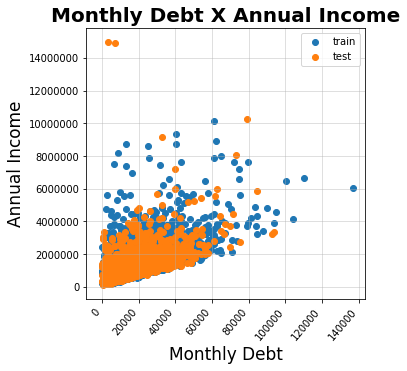

In [0]:
scatter(-3,1,5,5)

In [0]:
df.loc[df[col(-3)] > 100000, col(-3)] = 100000

In [0]:
df.loc[df[col(1)] > 8000000, col(1)] = df.loc[df[col(1)] > 8000000, col(1)] * 0.8
df_test.loc[df_test[col(1)] > 8000000, col(1)] = df_test.loc[df_test[col(1)] > 8000000, col(1)] * 0.8
df_test.loc[df_test[col(1)] > 8500000, col(1)] = 8000000

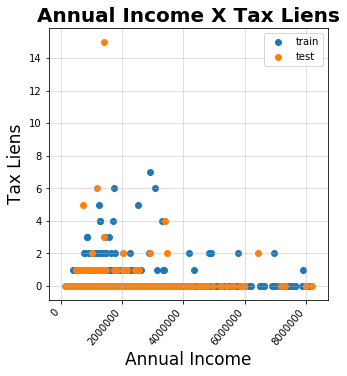

In [0]:
scatter(1,3,5,5)

In [0]:
liens_max = df[col(3)].max() - 1

df.loc[df[col(3)] > liens_max, col(3)] = liens_max
df_test.loc[df_test[col(3)] > liens_max, col(3)] = liens_max

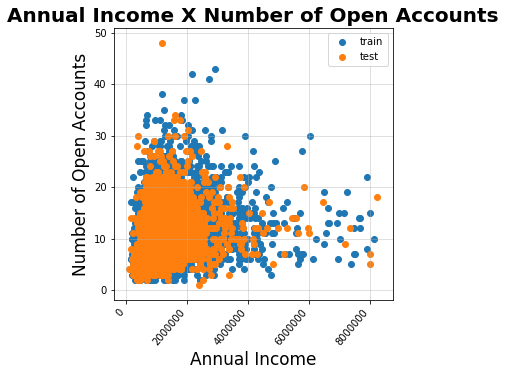

In [0]:
scatter(1,4,5,5)

In [0]:
df.loc[df[col(4)] > 38, col(4)] = 38
df_test.loc[df_test[col(4)] > 38, col(4)] = 38

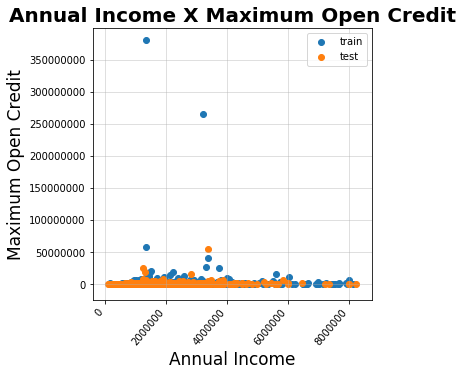

In [0]:
scatter(1,6,5,5)

In [0]:
df.loc[df[col(6)] > 25000000, col(6)] = 25000000
df_test.loc[df_test[col(6)] > 25000000, col(6)] = 25000000

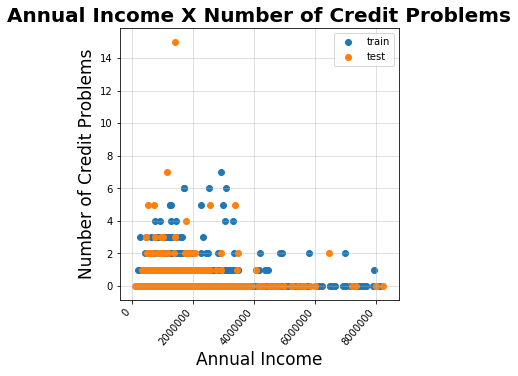

In [0]:
scatter(1,7,5,5)

In [0]:
df.loc[df[col(7)] > 6, col(7)] = 6
df_test.loc[df_test[col(7)] > 6, col(7)] = 6

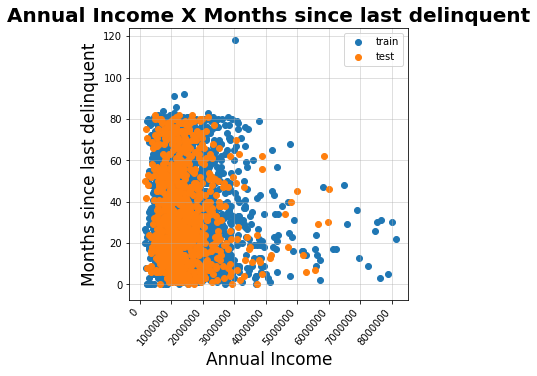

In [0]:
scatter(1,8,5,5)

In [0]:
df.loc[df[col(8)] > 92, col(8)] = 92

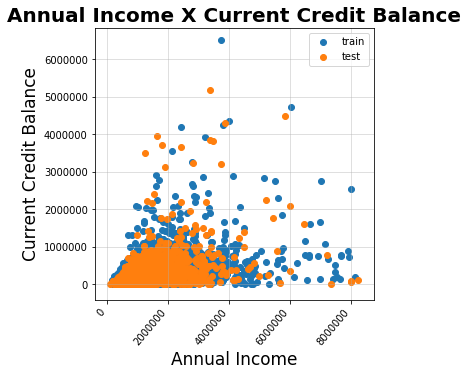

In [0]:
scatter(1,13,5,5)

In [0]:
df.loc[df[col(13)] >5000000, col(13)] = 5000000
df_test.loc[df_test[col(13)] >5000000, col(13)] = 5000000

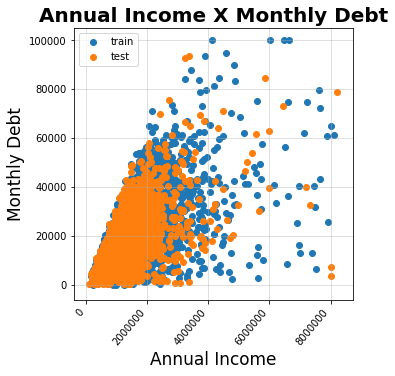

In [0]:
scatter(1,14,5,5)

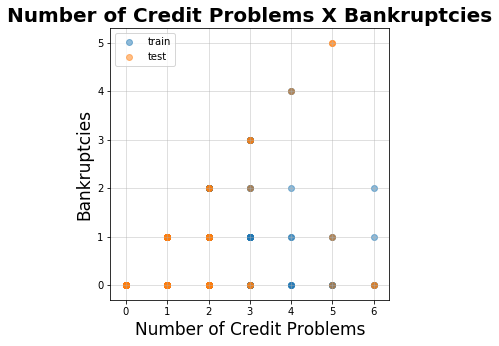

In [0]:
scatter(7,9,dft_alpha=.5, df_alpha=.5, rot=False)

# !

Как видно из графика разброса - в основном, проблемами с кредитом являются банкротства. Следовательно, если проблем не было - то и банкротств не было. На основе этого наблюдения можно заполнить пропуски в признаке "банкротства".

In [0]:
print(df.loc[df[col(9)].isna() == True, col(7)].value_counts())
print(df_test.loc[df_test[col(9)].isna() == True, col(7)].value_counts())

0.0    14
Name: Number of Credit Problems, dtype: int64
0.0    3
Name: Number of Credit Problems, dtype: int64


#!
Пропущенные значения в "банкротствах" имеют 0 в значениях "кол-во проблем с кредитом", следовательно - банкротств не было, и мы заполняем пропуски нулями.

In [0]:
df[col(9)] = df[col(9)].fillna(0)
df_test[col(9)] = df_test[col(9)].fillna(0)

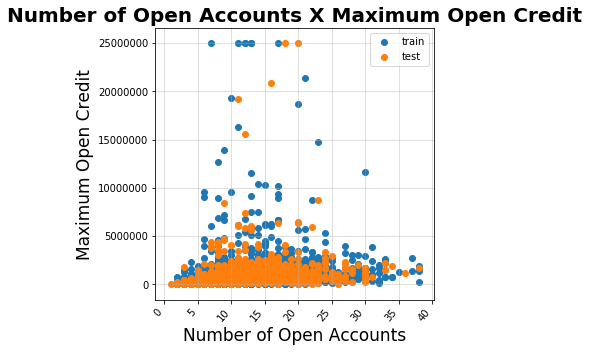

In [0]:
scatter(4,6)

# **Обработка пропусков**

##### Восстановим значения 'Annual Income' на основе линейной зависимости с 'Monthly Debt', используя линейную регрессию.Коэф. корреляции и не так велик (0.6), но все же связь близкая к линейной, хоть и с большим разбросом.

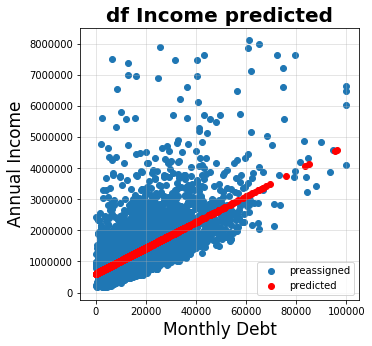

In [0]:
df.loc[df[col(1)].isna() == True, col(1)] = fill_income(df)

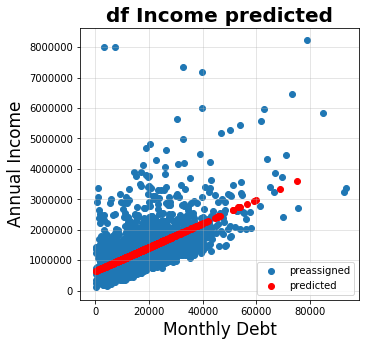

In [0]:
df_test.loc[df_test[col(1)].isna() == True, col(1)] = fill_income(df_test)

In [0]:
#  Признак из годового дохода / 12 месяцев - ежемесячный платеж

# free_money = (df[col(1)] / 12) - df[col(14)]
# one_percent = (df[col(1)] / 12) / 100
# free_money_percents = free_money / one_percent

In [0]:
# df['Free money'] = free_money
# df['Free money percents'] = free_money_percents

##### Заполнение "Years in current job" модой

In [0]:
df[col(2)] = df[col(2)].fillna('10+ years')
df_test[col(2)] = df_test[col(2)].fillna('10+ years')

##### Заполнение 'Months since last delinquent'

Около половины данных по этому признаку нет. И линейно он не зависим с другими признаками. Удалим его.

In [0]:
df = df.drop(col(8), axis=1)
df_test = df_test.drop('Months since last delinquent', axis=1)

##### Создание нового признака на основе выбросов по 'Credic score', т.к. они имеют таргет = 1.

In [0]:
df['Guaranteed win'] = 0
df.loc[(df[col(14)] > 6000) & (df[col(15)] == 1), 'Guaranteed win'] = 1

df_test['Guaranteed win'] = 0
df_test.loc[df_test[col(14)] > 6000, 'Guaranteed win'] = 1

##### Датафрейм без выбросов по Credit score

In [0]:
df_small = df.copy()

In [0]:
df_small = df_small.drop(df_small.loc[df_small['Credit Score'] > 6000].index)
df_small = df_small.drop('Guaranteed win', axis=1)

In [0]:
df_small_test = df_test.copy()

In [0]:
df_small_test = df_small_test.drop(df_small_test.loc[df_small_test['Credit Score'] > 6000].index)
df_small_test = df_small_test.drop('Guaranteed win', axis=1)

### Попробуем восстановить значения Credit score без выбросов, используя полиномиальную регрессию.

In [0]:
def score_fill(df_small):  
  feats = ['Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 
           'Years of Credit History', 'Monthly Debt', 'Current Credit Balance']
  target = 'Credit Score'

  poly_feats = PolynomialFeatures(degree=2, include_bias=False)

  train = df_small.loc[df_small['Credit Score'].isna() == False]
  test = df_small.loc[df_small['Credit Score'].isna() == True]

  X_train, y_train = train.loc[:, feats], train.loc[:, target]
  X_test, y_test = test.loc[:, feats], test.loc[:, target]

  X_train_poly = poly_feats.fit_transform(X_train)
  X_test_poly = poly_feats.fit_transform(X_test)

  LR = LinearRegression(fit_intercept=True, normalize=True)
  LR.fit(X_train_poly, y_train)
  y_target = LR.predict(X_test_poly)

  plt.scatter(train['Annual Income'], train['Credit Score'], label='Preassigned')
  plt.scatter(test['Annual Income'], y_target, c='r', label='Predicted')

  plt.ticklabel_format(style='plain')
  plt.xlabel('Annual Income', fontsize=17)
  plt.ylabel('Credit Score', fontsize=17)

  plt.title(f'df Credit Score predicted', size=20, fontweight='bold', color='w',)

  plt.grid(alpha=.4)
  plt.xticks(rotation=50, horizontalalignment='right')
  plt.legend()
  plt.show()
  
  return y_target

##### Результат предикта отобразим на графике, например, совместно с 'Annual Income'.

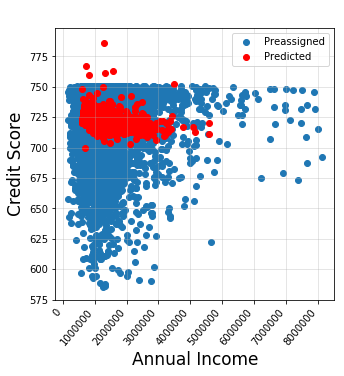

In [0]:
df.loc[df['Credit Score'].isna() == True, 'Credit Score'] = score_fill(df_small)

##### Немного ужмем выбросы Credit score сверху

In [0]:
df.loc[df['Credit Score'].between(750, 5000), 'Credit Score'] = df.loc[df['Credit Score'].between(750, 5000), 'Credit Score'] * 0.95

##### Результат предикта для тестового датасета.

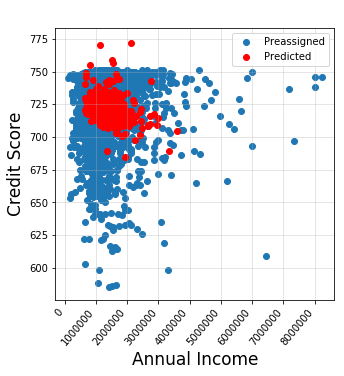

In [0]:
df_test.loc[df_test['Credit Score'].isna() == True, 'Credit Score'] = score_fill(df_small_test)

##### Так же немного подожмем выбросы.

In [0]:
df_test.loc[df_test['Credit Score'].between(750, 5000), 'Credit Score'] = df_test.loc[df_test['Credit Score'].between(750, 5000), 'Credit Score'] * 0.95

# **Подготовка данных**

In [0]:
df.loc[:,df.dtypes == 'int64'] = df.loc[:,df.dtypes == 'int64'].astype('int8') 
df['Credit Score'] = df['Credit Score'].round(0).astype('int32')

df_test.loc[:,df_test.dtypes == 'int64'] = df_test.loc[:,df_test.dtypes == 'int64'].astype('int8') 
df_test['Credit Score'] = df_test['Credit Score'].round(0).astype('int32')

##### Разделим признаки на числовые, категориальные и целевую переменную

In [0]:
target_col = 'Credit Default'
cat_cols = ['Home Ownership','Years in current job', 'Purpose', 'Term', 'Guaranteed win']
num_cols = list(set(df.columns) - set(cat_cols))
num_cols.remove(target_col)

##### Стандартизация числовых признаков

In [0]:
scaler = StandardScaler(with_mean=True)

df[num_cols] = scaler.fit_transform(df[num_cols])

In [0]:
df_test[num_cols] = scaler.fit_transform(df_test[num_cols])

##### One-hot-encoding

In [0]:
df = dummies_for_many(cat_cols, df)

In [0]:
df_test = dummies_for_many(cat_cols, df_test)

Некоторые модели ругаются на знак "<", поэтому заменим название признака.

In [0]:
df = df.rename(columns={'< 1 year':'less 1 year'})
df_test = df_test.rename(columns={'< 1 year':'less 1 year'})

# **Train-test-split**

In [0]:
df = df.drop('renewable energy', axis=1)

In [0]:
X = df.loc[:, df.columns != 'Credit Default']
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=.01, random_state=21, stratify=y)

### **Балансировка целевой переменной**

In [0]:
y_train.value_counts()

0    5333
1    2092
Name: Credit Default, dtype: int64

In [0]:
df_balanced = pd.concat([X_train, y_train], axis=1)

df_balanced = balance(df_balanced, 'Credit Default')

In [0]:
df_balanced['Credit Default'].value_counts()

1    5333
0    5333
Name: Credit Default, dtype: int64

In [0]:
y_train, X_train = df_balanced['Credit Default'], df_balanced.drop('Credit Default', axis=1)

# **Построение модели**

##### Catboost

In [0]:
%%time

catb = catboost.CatBoostClassifier(n_estimators=500, max_depth=5, learning_rate=0.01, silent=True, random_state=21)

catb.fit(X_train, y_train)

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_test)

CPU times: user 7.32 s, sys: 1.46 s, total: 8.78 s
Wall time: 4.62 s


In [0]:
report(y_train, y_test, y_train_pred, y_test_pred)

TRAIN 
               precision    recall  f1-score   support

           0       0.72      0.78      0.75      5333
           1       0.76      0.69      0.72      5333

    accuracy                           0.74     10666
   macro avg       0.74      0.74      0.74     10666
weighted avg       0.74      0.74      0.74     10666


CONFUSION MATRIX 
 [[4177 1156]
 [1657 3676]]
TEST 
               precision    recall  f1-score   support

           0       0.81      0.70      0.75        54
           1       0.43      0.57      0.49        21

    accuracy                           0.67        75
   macro avg       0.62      0.64      0.62        75
weighted avg       0.70      0.67      0.68        75

CONFUSION MATRIX 
 [[38 16]
 [ 9 12]]


# **Сохранение результата**

In [0]:
def save_submit(model, n, df_test=df_test):
  sub_pred = model.predict(df_test)
  df_test['id'] = df_test.index + 7500
  submit = pd.DataFrame({'id':df_test['id'], 'Credit Default':sub_pred}, dtype=np.int32)
  submit.to_csv(f'/content/drive/My Drive/Python for DS 2/AEvdokimov_predictions{str(n)}.csv', index=False) 
  df_test = df_test.drop('id', axis=1)  
  
  print(f'Сохранено под номером {n}')

### !В случае сохранения - выдернуть шнур, выдавить стекло, раскомментировать и запустить!

In [0]:
# save_submit(catb, 11)

## Неподошедшие модели.

In [0]:
# params = {'n_estimators': [100, 200, 400, 500, 800, 1000],
#           'max_depth': [2, 4, 6, 8, 12, 14, 16],
#           'learning_rate':[0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]}

In [0]:
# cv = KFold(n_splits=3, random_state=21, shuffle=True)

In [0]:
# %%time

# rs = RandomizedSearchCV(catb, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(X_train, y_train)

##### XGBoost

In [0]:
# xgb = xgboost.XGBClassifier(n_estimators=800, max_depth=8, learning_rate=0.1, random_state=21)

# xgb.fit(X_train, y_train)

# y_train_pred = xgb.predict(X_train)
# y_test_pred = xgb.predict(X_test)

# report(y_train, y_test, y_train_pred, y_test_pred)

In [0]:
# %%time

# rs = RandomizedSearchCV(xgb, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(X_train, y_train)

In [0]:
# rs.best_score_

In [0]:
# rs.best_params_

##### LightGBM

In [0]:
# lgbm = lightgbm.LGBMClassifier(n_estimators=1000, learning_rate=0.2, max_depth=12, random_state=21)

# lgbm.fit(X_train, y_train)

# y_train_pred = lgbm.predict(X_train)
# y_test_pred = lgbm.predict(X_test)

# report(y_train, y_test, y_train_pred, y_test_pred)

In [0]:
# %%time

# rs = RandomizedSearchCV(lgbm, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(X_train, y_train)

In [0]:
# rs.best_score_

In [0]:
# rs.best_params_

##### KNN

In [0]:
# knn = KNeighborsClassifier()

# knn.fit(X_train, y_train)

# y_train_pred = knn.predict(X_train)
# y_test_pred = knn.predict(X_test)

# report(y_train, y_test, y_train_pred, y_test_pred)

##### Logistic Regression

In [0]:
# lr = LogisticRegression(random_state=21)

# lr.fit(X_train, y_train)

# y_train_pred = lr.predict(X_train)
# y_test_pred = lr.predict(X_test)

# report(y_train, y_test, y_train_pred, y_test_pred)

In [0]:
# rfc = RandomForestClassifier(max_depth=16, max_features=6, n_estimators=1000, random_state=21)

# rfc.fit(X_train, y_train)

# y_train_pred = rfc.predict(X_train)
# y_test_pred = rfc.predict(X_test)

# report(y_train, y_test, y_train_pred, y_test_pred)

In [0]:
# params_rfc = {'n_estimators': [100, 200, 400, 500, 800, 1000],
#           'max_depth': [2, 4, 6, 8, 12, 14, 16],
#              'max_features': [2,4,6,8,10]}

In [0]:
# %%time

# rs = RandomizedSearchCV(rfc, params_rfc, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(X_train, y_train)

In [0]:
# rs.best_score_

In [0]:
# rs.best_params_

# **Voting**

In [0]:
# svc = SVC(probability=True)

# voting = VotingClassifier(
#   estimators=[('knn', knn), ('svc', svc), ('catb', catb), ('rfc', rfc)], voting='soft')

# voting.fit(X_train, y_train)

In [0]:
# y_train_pred = voting.predict(X_train)
# y_test_pred = voting.predict(X_test)

# report(y_train, y_test, y_train_pred, y_test_pred)

In [0]:
# df_test = df_test.drop('id', axis=1)  

In [0]:
# save_submit(voting,8)